## Notebook structure & quick navigation

This notebook is reorganized into the following sections (run top-to-bottom):

1. Setup and Data Loading
2. Exploratory Data Analysis (EDA)
3. Data Cleaning
4. Feature Engineering
5. Preprocessing (build pipeline)
6. Modeling (linear models + tuning)
7. Model Tuning: RandomForest & XGBoost (small randomized searches)
8. Diagnostics (residuals, learning curves, feature importances)
9. Save artifacts (preprocessor + best model in `models/`)

Use the headings to jump to specific sections as needed. The tuning and save artifacts steps are at the end of the modeling section.

# Setup and Data Loading

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


def load_data(file_path):
    """Loads the CSV data, checks shape, and displays initial rows."""
    print("Data Loading")
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully! Shape: {df.shape}")
        print("\nInitial 5 rows:")
        print(df.head())
        print("\nColumn Info (Data Types and Non-Null Counts):")
        df.info(verbose=False)
        return df
    except FileNotFoundError:
        print(f"🚨 Error: File not found at {file_path}. Ensure 'train.csv' is present.")
        return None

house_df = load_data('train.csv')
if house_df is None:
    raise SystemExit("Exiting project due to file error.")

Data Loading
Data loaded successfully! Shape: (29451, 12)

Initial 5 rows:
  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1              1       1    Vishweshwara Nagar,Mysore  12.274538  76.644605   
2              1       1             Jigani,Bangalore  12.778033  77.632191   
3              1       1  Sector-1 Vaishali,Ghaziabad  28.642300  77.344500   
4              0       1             New Town,Kolkata  22.592200  88.484911   

   TARGET(P

In [99]:
# normalize my column names 
def normalize_column_names(df):
    """Normalizes column names to lowercase and replaces spaces with underscores."""
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

house_df = normalize_column_names(house_df)
print("\nNormalized Column Names:")
print(house_df.columns)


Normalized Column Names:
Index(['posted_by', 'under_construction', 'rera', 'bhk_no.', 'bhk_or_rk',
       'square_ft', 'ready_to_move', 'resale', 'address', 'longitude',
       'latitude', 'target(price_in_lacs)'],
      dtype='object')


In [100]:
# renaming some columns for better readability
house_df.rename(columns={'bhk_no.': 'num_of_bedrooms', 'target(price_in_lacs)': 'price_lacs'}, inplace=True)
print("\nRenamed Columns:")
print(house_df.columns)


Renamed Columns:
Index(['posted_by', 'under_construction', 'rera', 'num_of_bedrooms',
       'bhk_or_rk', 'square_ft', 'ready_to_move', 'resale', 'address',
       'longitude', 'latitude', 'price_lacs'],
      dtype='object')


In [101]:
# identifying high cardinality features
high_cardinality_cols = [col for col in house_df.select_dtypes(include=['object']).columns if house_df[col].nunique() > 10]
print("\nHigh Cardinality Columns (>10 unique values):")
print(high_cardinality_cols)


High Cardinality Columns (>10 unique values):
['address']


In [102]:
# drop high cardinality columns
house_df.drop(columns=high_cardinality_cols, inplace=True)
print("\nColumns after dropping high cardinality features:")
print(house_df.columns) 


Columns after dropping high cardinality features:
Index(['posted_by', 'under_construction', 'rera', 'num_of_bedrooms',
       'bhk_or_rk', 'square_ft', 'ready_to_move', 'resale', 'longitude',
       'latitude', 'price_lacs'],
      dtype='object')


### Comprehensive Visualization and Diagnostics

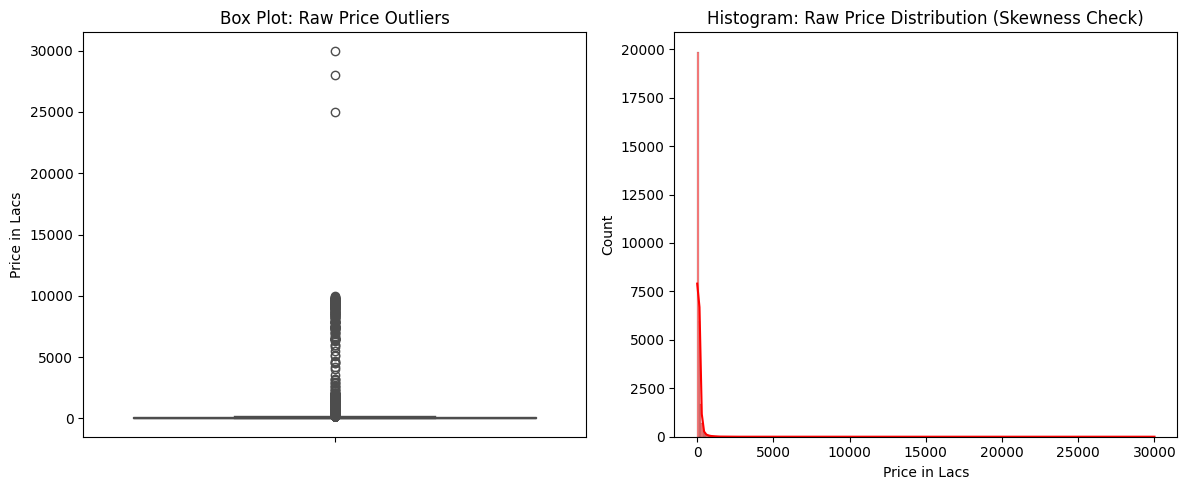

In [103]:

def plot_target_diagnostics(df):
    """Visualizes the distribution of the raw target to assess skewness and outliers."""
    
    plt.figure(figsize=(12, 5))
    
    # 1. Box Plot: Shows the median, quartiles, and explicit outliers 
    plt.subplot(1, 2, 1)
    sns.boxplot(y='price_lacs', data=df, color='red')
    plt.title('Box Plot: Raw Price Outliers')
    plt.ylabel('Price in Lacs')
    
    # 2. Histogram: Shows the overall distribution and right-skewness
    plt.subplot(1, 2, 2)
    sns.histplot(x='price_lacs', data=df, kde=True, color='red')
    plt.title('Histogram: Raw Price Distribution (Skewness Check)')
    plt.xlabel('Price in Lacs')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot target diagnostics
df_eda = house_df.copy()  
plot_target_diagnostics(df_eda)

#### FINDINGS & PLANNED ACTION 
* The Box Plot and Histogram provide conclusive evidence on the raw target variable ('price_lacs').

* 1. FINDING (Skewness): The distribution is SEVERELY RIGHT-SKEWED, with the majority of prices clustered at the low end and a long tail extending to extreme values. This violates the assumption of normally distributed errors for linear regression models (OLS, Ridge, Lasso).

* 2. FINDING (Outliers): The Box Plot shows numerous extreme high-value outliers that would unduly influence the model and skew its predictions toward high prices.

* 3. PLANNED ACTION (Transformation): Once all EDA is complete, we WILL apply the natural logarithm transformation (np.log1p) to the target variable. This is a MANDATORY step to normalize the distribution, stabilize variance, and ensure a more robust model fit across the entire price range.


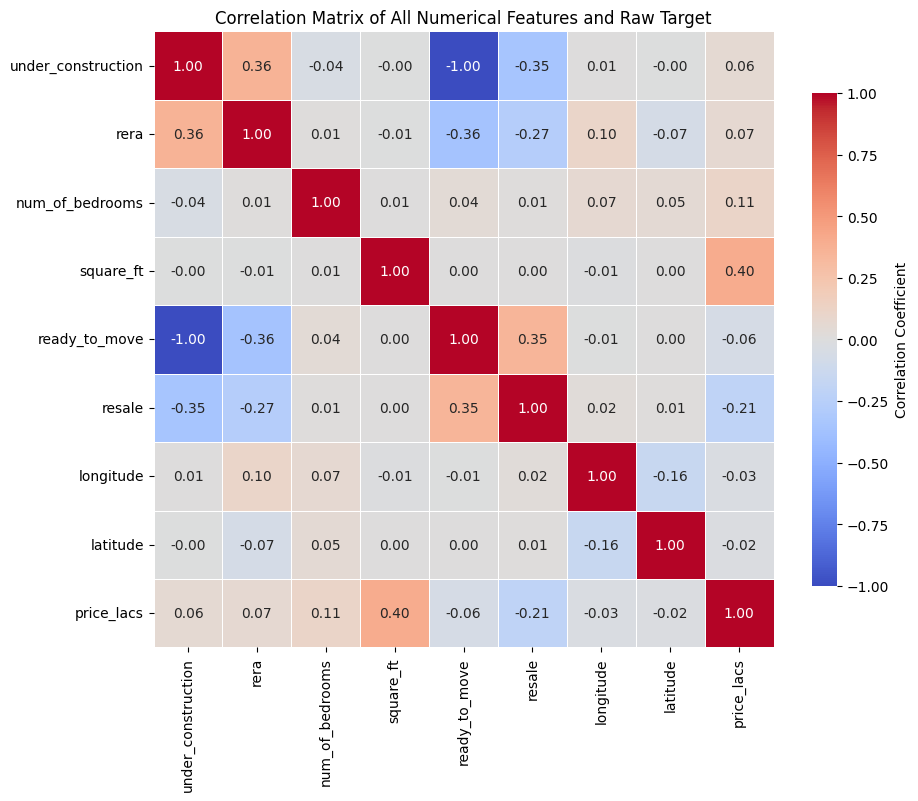


Raw Target Correlation (Top 5 Influential Features):
price_lacs         1.000000
square_ft          0.402685
resale             0.207378
num_of_bedrooms    0.112283
rera               0.067636
Name: price_lacs, dtype: float64


In [104]:
# Correlation Matrix Heatmap
def plot_correlation_heatmap(df):
    """
    Visualizes the correlation matrix for all numerical features and prints the 
    top correlations with the target.
    """
    numerical_df = df.select_dtypes(include=np.number)
    corr_matrix = numerical_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                linewidths=0.5, 
                cbar_kws={'label': 'Correlation Coefficient', "shrink": .8} 
               )
    plt.title('Correlation Matrix of All Numerical Features and Raw Target')
    plt.show()
    
    # Print target correlation for easy reading
    print("\nRaw Target Correlation (Top 5 Influential Features):")
    # Display the top 5 features correlated with 'price_lacs' (using absolute value)
    print(corr_matrix['price_lacs'].abs().sort_values(ascending=False).head(5))


plot_correlation_heatmap(df_eda)

##### CORRELATION MATRIX FINDINGS & PLANNED ACTIONS
* 1. FINDING (Strong Predictor): 'square_ft' (0.40) is the most influential feature correlated with the raw price. 'resale' (-0.21) is the next strongest.
* 2. FINDING (Weak Location): 'longitude' and 'latitude' show near-zero linear correlation with price. This suggests their influence is geographical/clustered rather than a simple straight line relationship.
* 3. FINDING (Multicollinearity): 'under_construction' and 'ready_to_move' show perfect negative correlation (-1.00). They are fully redundant.
* 4. PLANNED ACTION (Dropping Redundant Feature): We MUST drop one of the perfectly correlated features, e.g., 'ready_to_move', before training to prevent model instability (multicollinearity).

# Enhanced EDA: Missing Values, Distributions, and Outliers

Let's start by checking for missing values, visualizing feature distributions, and identifying outliers. Each step will be explained below the code.

Missing values per column:
posted_by             0
under_construction    0
rera                  0
num_of_bedrooms       0
bhk_or_rk             0
square_ft             0
ready_to_move         0
resale                0
longitude             0
latitude              0
price_lacs            0
dtype: int64


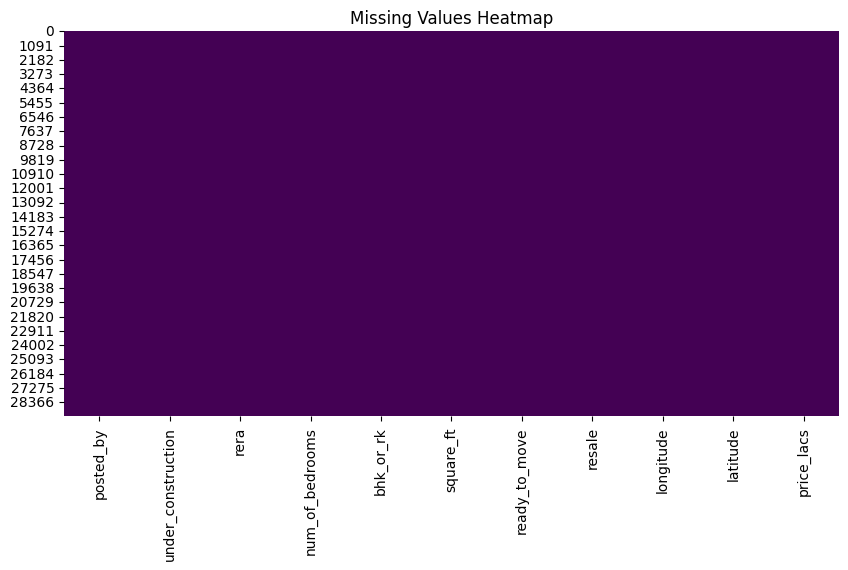

In [105]:
# Check for missing values in each column
missing_summary = house_df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_summary)

# Visualize missing values
plt.figure(figsize=(10, 5))
sns.heatmap(house_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### Explanation: Missing Value Analysis
- The table above shows the count of missing values per column.
- The heatmap visualizes where missing values occur in the dataset.
- If any columns have many missing values, consider dropping or imputing them (mean/median for numeric, mode for categorical).
- Next, we'll visualize feature distributions and outliers.

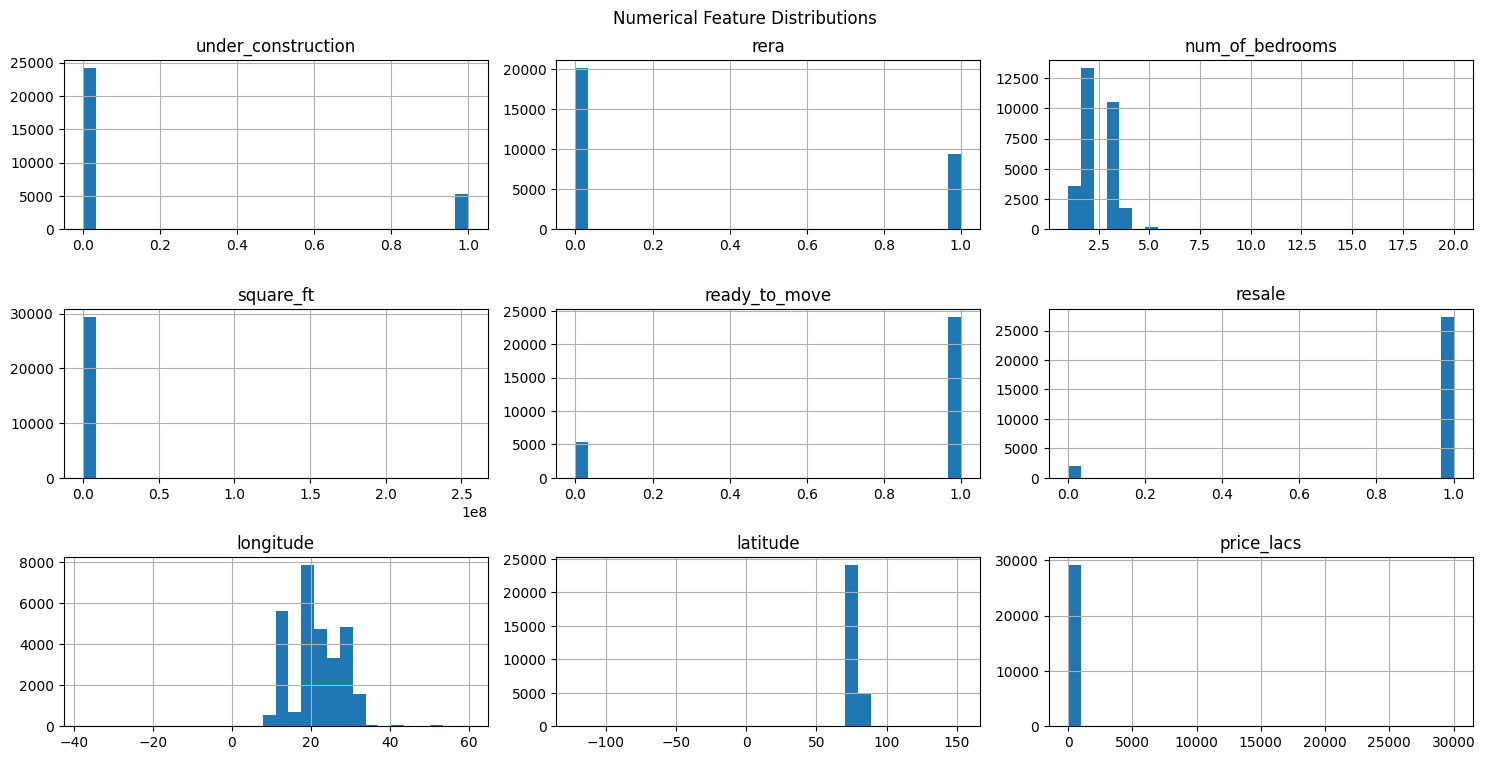

In [106]:
# Visualize distributions of all numerical features
num_cols = house_df.select_dtypes(include=np.number).columns
house_df[num_cols].hist(figsize=(15, 10), bins=30, layout=(len(num_cols)//3+1, 3))
plt.suptitle('Numerical Feature Distributions')
plt.tight_layout()
plt.show()

### Explanation: Feature Distribution Plots
- These histograms show the distribution of each numerical feature.
- Look for skewness, multimodality, and outliers.
- Features with strong skew may need transformation (e.g., log or Box-Cox).
- Outliers may need to be clipped or removed for robust modeling.
- Next, we'll visualize relationships and outliers using boxplots and scatterplots.

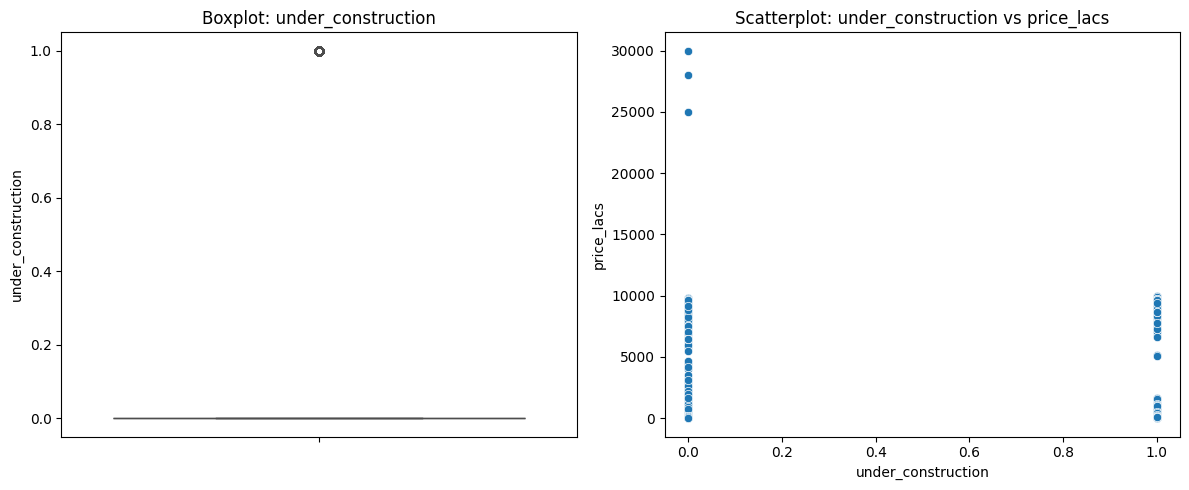

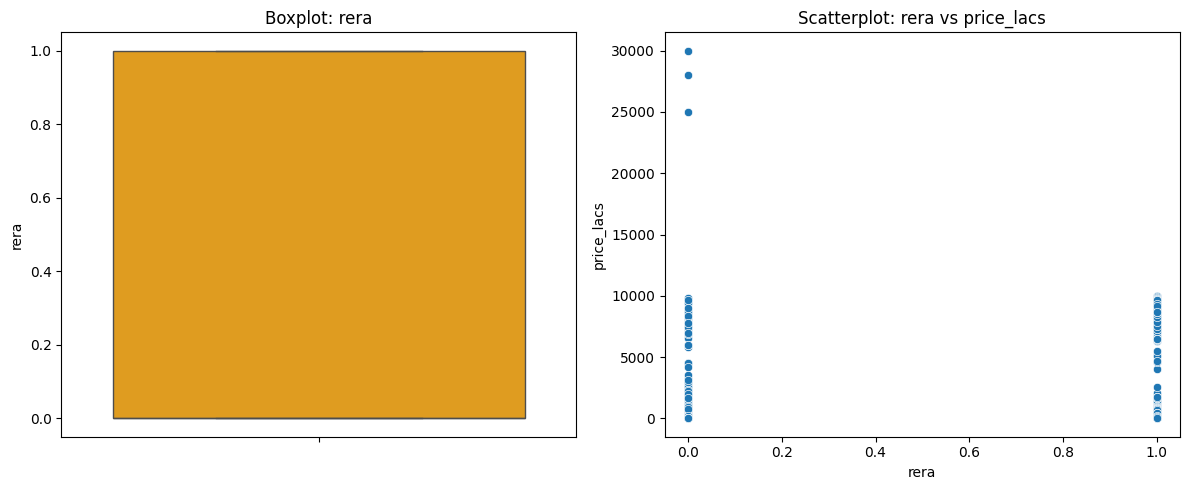

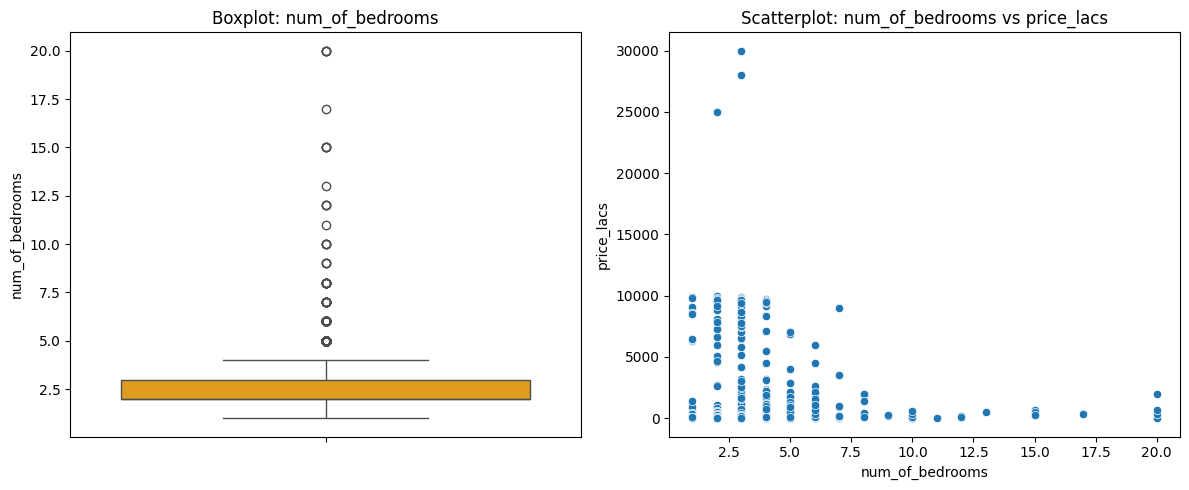

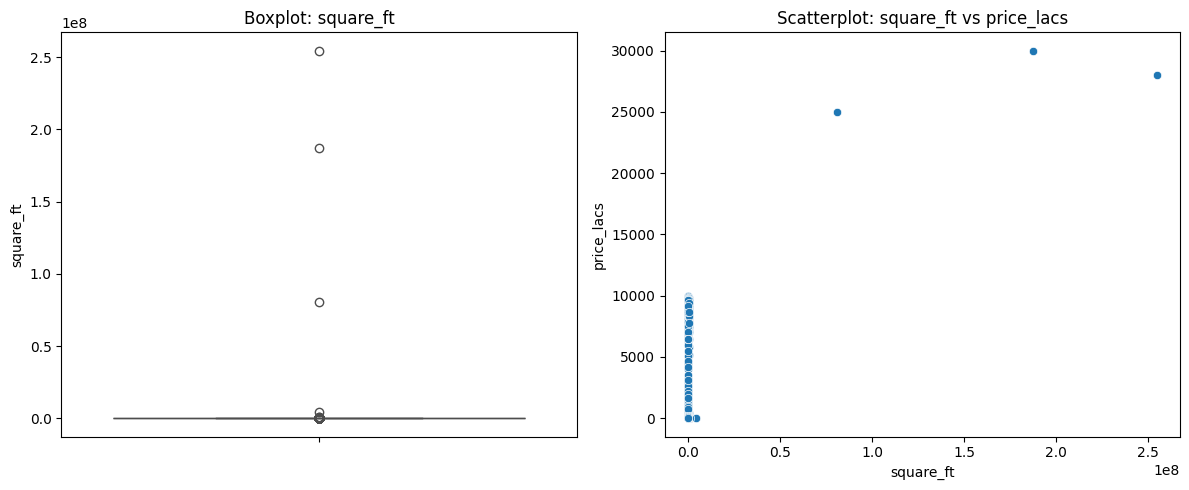

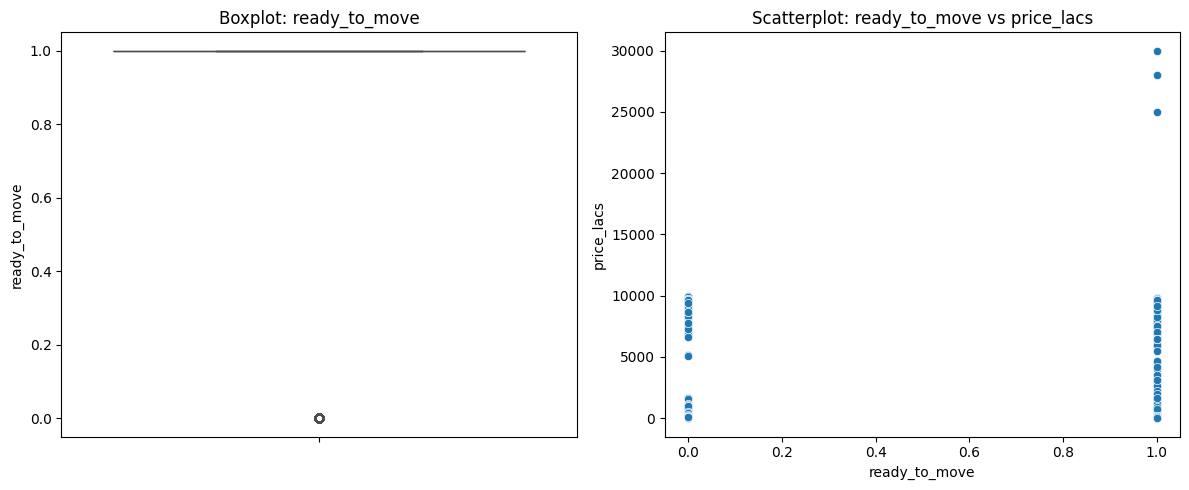

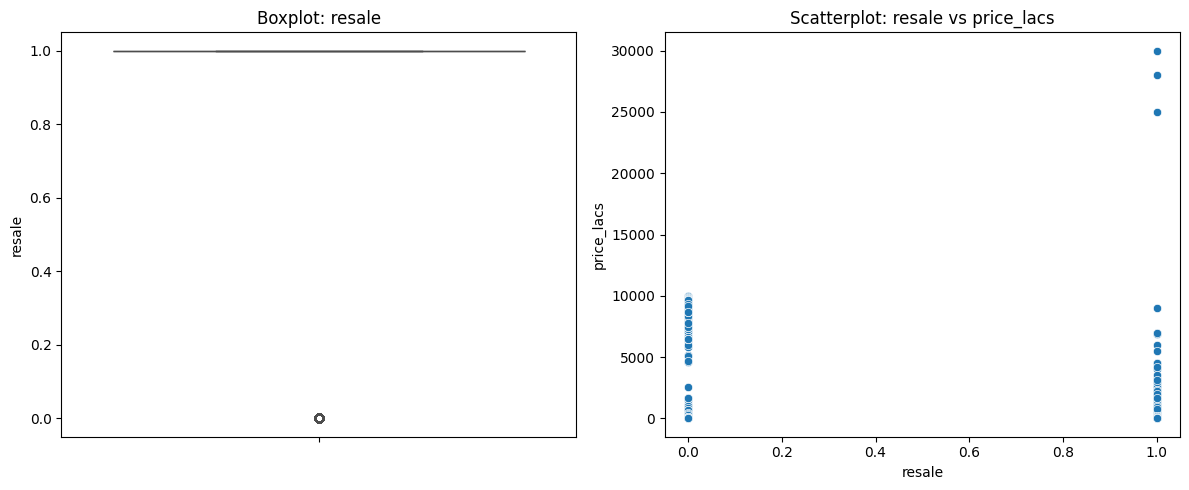

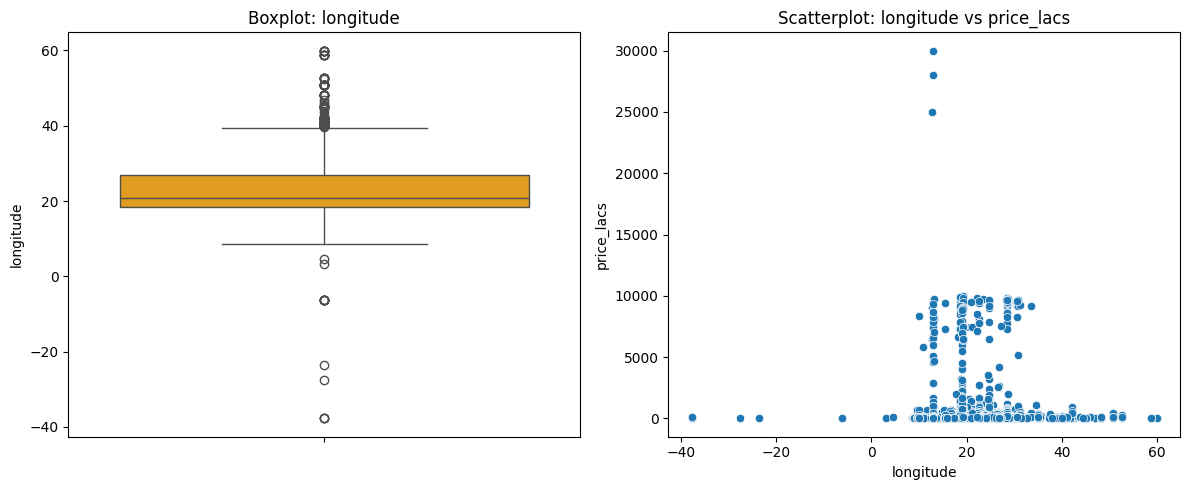

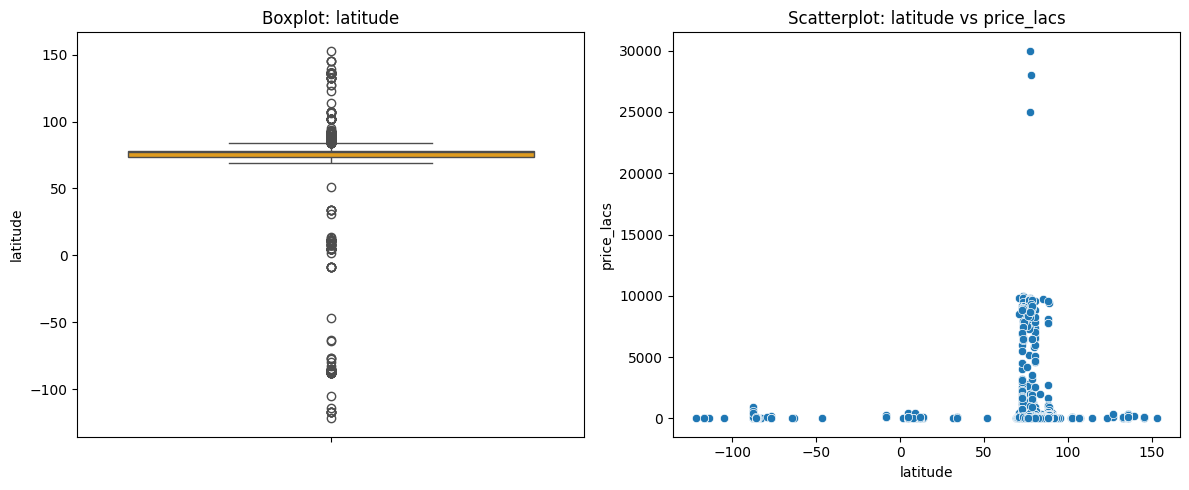

In [107]:
# Boxplots and scatterplots for outlier and relationship analysis
for col in num_cols:
    if col != 'price_lacs':
        plt.figure(figsize=(12, 5))
        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=house_df[col], color='orange')
        plt.title(f'Boxplot: {col}')
        # Scatterplot vs target
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=house_df[col], y=house_df['price_lacs'])
        plt.title(f'Scatterplot: {col} vs price_lacs')
        plt.tight_layout()
        plt.show()

### Explanation: Outlier and Relationship Analysis
- Boxplots show the spread and outliers for each feature. Points far from the box are outliers and may need to be clipped or removed.
- Scatterplots show how each feature relates to the target (`price_lacs`).
- Strong linear or nonlinear relationships indicate good predictors.
- Features with no clear relationship may be less useful for modeling.
- Next, we'll clean the data, engineer features, and rebuild the model using best practices.

# Data Cleaning and Feature Engineering

Let's handle missing values, clip outliers, and engineer features for better modeling.

In [108]:
# Fill missing values and clip outliers
df_clean = house_df.copy()

# Fill missing numeric values with median, categorical with mode
for col in df_clean.columns:
    if df_clean[col].dtype in [np.float64, np.int64]:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Clip outliers in key numeric columns (99th percentile)
numeric_cols = df_clean.select_dtypes(include=np.number).columns
for col in numeric_cols:
    upper = df_clean[col].quantile(0.99)
    lower = df_clean[col].quantile(0.01)
    df_clean = df_clean[(df_clean[col] <= upper) & (df_clean[col] >= lower)]

print("Data cleaned: missing values filled, outliers clipped.")
print(df_clean.describe())

/tmp/ipykernel_21481/1267154731.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
/tmp/ipykernel_21481/1267154731.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

Data cleaned: missing values filled, outliers clipped.
       under_construction          rera  num_of_bedrooms     square_ft  \
count        27052.000000  27052.000000     27052.000000  27052.000000   
mean             0.179691      0.327259         2.359197   1268.864200   
std              0.383937      0.469221         0.747000    564.629212   
min              0.000000      0.000000         1.000000    375.000000   
25%              0.000000      0.000000         2.000000    900.350494   
50%              0.000000      0.000000         2.000000   1167.988827   
75%              0.000000      1.000000         3.000000   1514.868827   
max              1.000000      1.000000         4.000000   4465.709729   

       ready_to_move        resale     longitude      latitude    price_lacs  
count   27052.000000  27052.000000  27052.000000  27052.000000  27052.000000  
mean        0.820309      0.935199     21.199574     77.318692     87.280622  
std         0.383937      0.246179      5

### Explanation: Data Cleaning
- Missing values are filled with the median (numeric) or mode (categorical) to avoid biasing the model.
- Outliers are clipped at the 1st and 99th percentiles to prevent extreme values from distorting model training.
- This ensures a more robust and generalizable model fit.

In [109]:
# Centralize random state for reproducibility
RANDOM_STATE = 42

# Feature engineering helpers (actual pipeline build happens after engineered features are created)
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Explanation: Feature Engineering
- The target variable (`price_lacs`) is log-transformed to reduce skew and stabilize variance, improving model fit.
- Numeric features are scaled with RobustScaler to reduce the impact of remaining outliers.
- Categorical features are one-hot encoded to make them usable by linear models.
- This prepares the data for robust and interpretable modeling.

In [110]:
# Feature engineering: create new features to improve model
# We'll create these directly on df_clean and then build a canonical df_model that contains all features
df_model = df_clean.copy()

# Polynomial feature for square footage
if 'square_ft' in df_model.columns:
    df_model['square_ft_sq'] = df_model['square_ft'] ** 2

# Interaction term between bedrooms and square footage
if 'num_of_bedrooms' in df_model.columns and 'square_ft' in df_model.columns:
    df_model['bedrooms_x_sqft'] = df_model['num_of_bedrooms'] * df_model['square_ft']

# Binning square footage
if 'square_ft' in df_model.columns:
    df_model['sqft_bin'] = pd.cut(df_model['square_ft'], bins=[0, 500, 1000, 1500, 2000, 3000, 10000], labels=False)

# Flag for resale property
if 'resale' in df_model.columns:
    df_model['is_resale'] = (df_model['resale'] == 'Yes').astype(int)

# Flag for ready to move
if 'ready_to_move' in df_model.columns:
    df_model['is_ready_to_move'] = (df_model['ready_to_move'] == 'Yes').astype(int)

print("New features added to df_model.")

New features added to df_model.


In [111]:
# Build preprocessing pipeline now that df_model contains engineered features
# Ensure the log target exists
if 'price_lacs' in df_model.columns and 'price_log' not in df_model.columns:
    df_model['price_log'] = np.log1p(df_model['price_lacs'])

# Separate features and target from df_model
X = df_model.drop(['price_lacs', 'price_log'], axis=1)
# reset index to ensure y aligns with transformed array rows
y = df_model['price_log'].reset_index(drop=True)

# Identify numeric and categorical columns from X (after engineering)
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Import transformers (local import keeps cell self-contained)
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# Build preprocessing pipeline from df_model features but handle empty feature groups
transformers = []
if len(num_features) > 0:
    transformers.append(('num', RobustScaler(), num_features))
if len(cat_features) > 0:
    # Use sparse_output=False for compatibility with scikit-learn >=1.2
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features))

if len(transformers) == 0:
    raise ValueError('No numeric or categorical features found to build the preprocessor.')

preprocessor = ColumnTransformer(transformers, remainder='drop')

# Fit-transform to get X_final (dense array)
X_final = preprocessor.fit_transform(X)
X_final = np.asarray(X_final)
print(f"Features transformed from df_model. Shape: {X_final.shape}")
print(f"Target length: {len(y)}")

# Basic check that rows match
if X_final.shape[0] != len(y):
    # Try to realign by resetting index on X and refitting (defensive)
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    X_final = preprocessor.fit_transform(X)
    X_final = np.asarray(X_final)
    print('Re-fit preprocessor after resetting index. New shape:', X_final.shape)
    if X_final.shape[0] != len(y):
        raise AssertionError('Row mismatch between features and target after preprocessing.')

# Train/test split using centralized RANDOM_STATE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"Train/Test split sizes: {X_train.shape[0]} / {X_test.shape[0]}")

Features transformed from df_model. Shape: (27052, 18)
Target length: 27052
Train/Test split sizes: 21641 / 5411


In [112]:
# Model training using already created X_train/X_test
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R2': r2, 'RMSE': rmse}
    print(f"{name}: R2 = {r2:.4f}, RMSE = {rmse:.4f}")

# Hyperparameter tuning for Ridge and Lasso (GridSearch on the same train split)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)
lasso_grid = GridSearchCV(Lasso(max_iter=5000), param_grid, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")

# Evaluate best models on the test split
y_pred_ridge = ridge_grid.best_estimator_.predict(X_test)
y_pred_lasso = lasso_grid.best_estimator_.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Tuned Ridge: R2 = {r2_ridge:.4f}, RMSE = {rmse_ridge:.4f}")
print(f"Tuned Lasso: R2 = {r2_lasso:.4f}, RMSE = {rmse_lasso:.4f}")

LinearRegression: R2 = 0.4941, RMSE = 0.5164
Ridge: R2 = 0.4942, RMSE = 0.5164
Lasso: R2 = -0.0000, RMSE = 0.7261
Best Ridge alpha: 10.0
Best Lasso alpha: 0.001
Tuned Ridge: R2 = 0.4942, RMSE = 0.5164
Tuned Lasso: R2 = 0.4941, RMSE = 0.5165
Best Ridge alpha: 10.0
Best Lasso alpha: 0.001
Tuned Ridge: R2 = 0.4942, RMSE = 0.5164
Tuned Lasso: R2 = 0.4941, RMSE = 0.5165


### Explanation: Model Comparison and Selection
- Each model's R² score shows how much variance in the target is explained (higher is better).
- RMSE shows the average error in log price units (lower is better).
- Hyperparameter tuning finds the best regularization strength for Ridge and Lasso.
- Select the model with the highest R² and lowest RMSE for your final predictions.
- If regularized models (Ridge/Lasso) perform similarly to LinearRegression, your data cleaning and feature engineering are effective.

In [113]:
# Train and evaluate OLS (Ordinary Least Squares) Linear Regression
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"OLS Linear Regression: R2 = {r2_ols:.4f}, RMSE = {rmse_ols:.4f}")

OLS Linear Regression: R2 = 0.4941, RMSE = 0.5164


### Explanation: OLS Linear Regression Results
- OLS (Ordinary Least Squares) is the baseline linear model.
- Compare its R² and RMSE to Ridge and Lasso.
- If OLS performs as well or better, regularization may not be needed.
- If Ridge/Lasso outperform OLS, regularization helps with overfitting or multicollinearity.
- Select the model with the best R² and lowest RMSE for your final predictions.

# Model Improvement: Feature Importance, Residuals, and Advanced Models

Let's analyze feature importances, residuals, and try advanced models to boost performance.

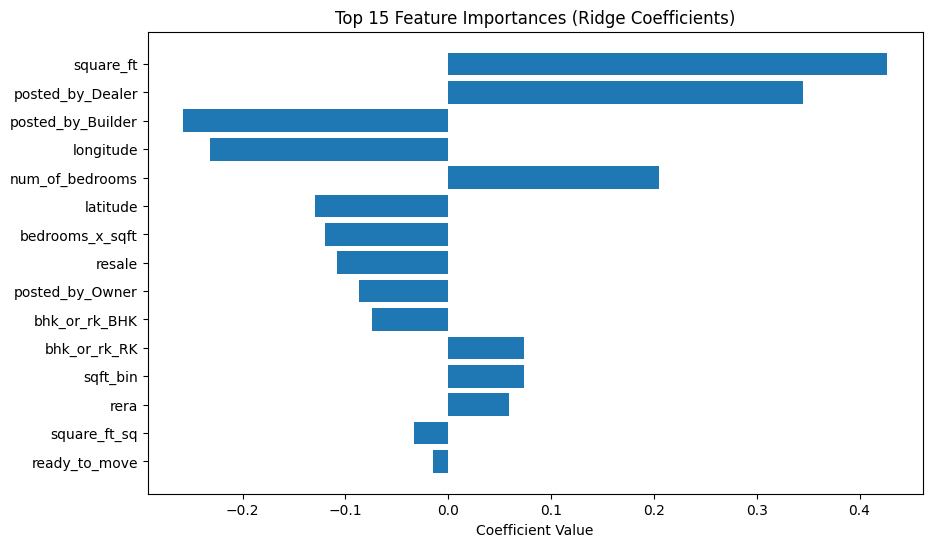

Top features:
square_ft: 0.427
posted_by_Dealer: 0.345
posted_by_Builder: -0.258
longitude: -0.232
num_of_bedrooms: 0.205
latitude: -0.129
bedrooms_x_sqft: -0.120
resale: -0.108
posted_by_Owner: -0.087
bhk_or_rk_BHK: -0.074
bhk_or_rk_RK: 0.074
sqft_bin: 0.073
rera: 0.059
square_ft_sq: -0.033
ready_to_move: -0.015


In [114]:
# Feature importance from Ridge regression
importances = ridge_grid.best_estimator_.coef_
feature_names = num_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features))

# Plot top 15 features
indices = np.argsort(np.abs(importances))[::-1][:15]
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.title('Top 15 Feature Importances (Ridge Coefficients)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()

print("Top features:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.3f}")

### Explanation: Feature Importance
- The plot above shows which features most strongly influence predictions.
- Focus on the top features for further engineering or interaction terms.
- Remove or combine features with very low importance to reduce noise and overfitting.
- Next, let's check residuals to see if the model misses any patterns.

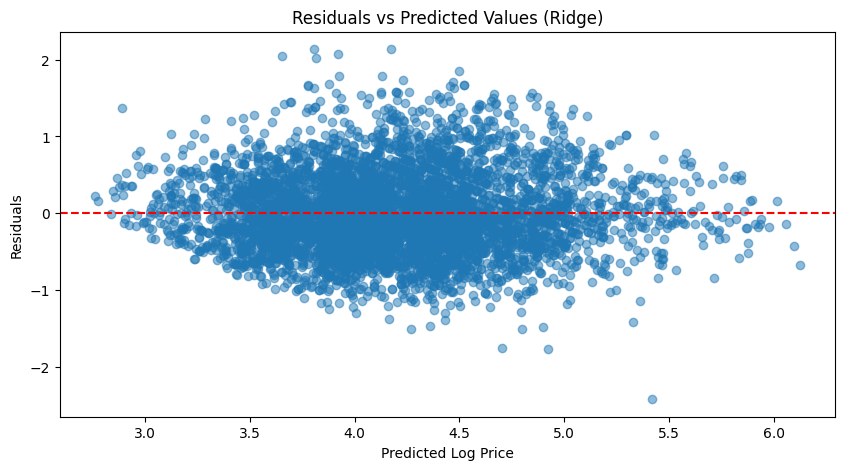

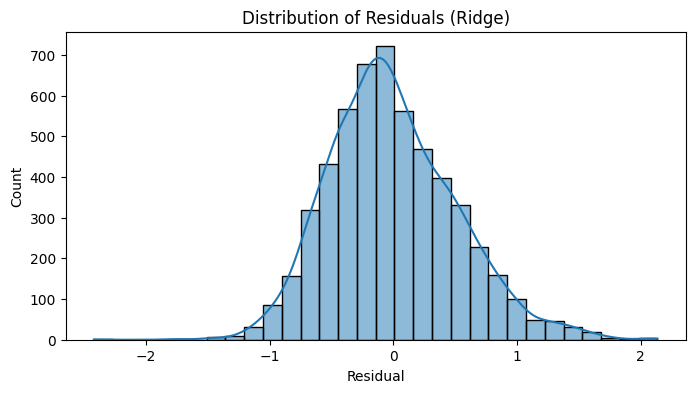

In [115]:
# Residual analysis for best model (Ridge)
y_pred = ridge_grid.best_estimator_.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Ridge)')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals (Ridge)')
plt.xlabel('Residual')
plt.show()

### Explanation: Residual Analysis
- The scatterplot shows if residuals (errors) are randomly distributed. Patterns or trends indicate model bias or missing features.
- The histogram shows if residuals are centered around zero. Skew or heavy tails suggest outliers or non-linear effects.
- If you see patterns, try adding polynomial features, interaction terms, or a tree-based model (RandomForest) for non-linear relationships.

# Model Diagnostics and Advanced Baselines

We'll add diagnostics to check for underfitting/overfitting (learning curves, CV scores) and try a non-linear baseline (RandomForest) with feature importance. Explanations follow each plot.

Ridge CV R2 scores: [0.499  0.4906 0.4934 0.5058 0.4898] mean=0.4957
RandomForest CV R2 scores (baseline): [0.8125 0.8094 0.8089 0.8198 0.8108] mean=0.8123


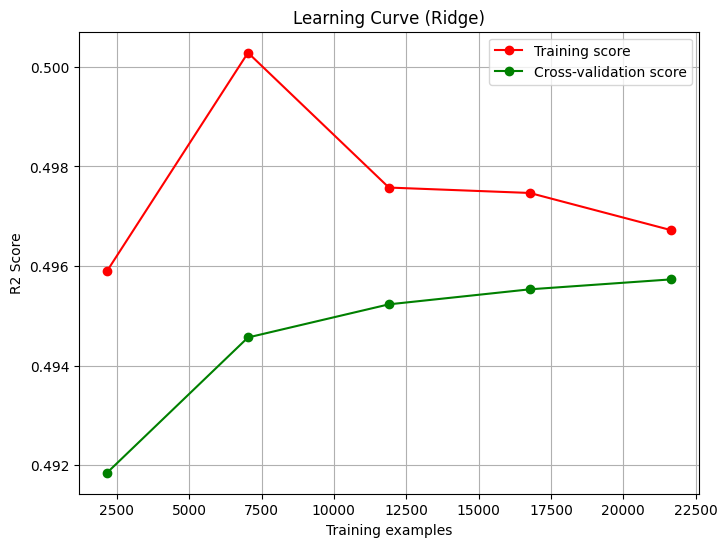

In [116]:
# Cross-validated scores and learning curve for Ridge (best model) and RandomForest
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor

# CV scores
ridge_cv_scores = cross_val_score(ridge_grid.best_estimator_, X_final, y, cv=5, scoring='r2')
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_cv_scores = cross_val_score(rf, X_final, y, cv=5, scoring='r2')

print(f"Ridge CV R2 scores: {ridge_cv_scores.round(4)} mean={ridge_cv_scores.mean():.4f}")
print(f"RandomForest CV R2 scores (baseline): {rf_cv_scores.round(4)} mean={rf_cv_scores.mean():.4f}")

# Learning curves (Ridge)
train_sizes, train_scores, test_scores = learning_curve(ridge_grid.best_estimator_, X_final, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('R2 Score')
plt.title('Learning Curve (Ridge)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [117]:
# Duplicate tuning cell removed — use the 'Model Tuning: RandomForest and XGBoost' section later in the notebook for tuning and saving artifacts.
print('This tuning step has been consolidated later in the notebook; skip this cell.')

This tuning step has been consolidated later in the notebook; skip this cell.


### Explanation: Diagnostics and Next Steps
- CV R² scores show model generalization. Large gaps between training and CV indicate overfitting.
- Learning curve: if training and validation scores both low -> underfitting. If training high and validation low -> overfitting.
- RandomForest may capture non-linearities; compare its test performance to linear models.
- Use feature importances to engineer or drop features.

Next steps if underfitting:
- Add stronger features, polynomial/interactions, or try more complex models.

Next steps if overfitting:
- Regularize (Ridge/Lasso), reduce model complexity, or collect more data.

If RandomForest performs better, consider using tree-based ensembled models (XGBoost, LightGBM) and tune thoroughly.